In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
ls

gdrive/  sample_data/


In [4]:
cd gdrive/

/content/gdrive


In [5]:
ls

MyDrive/


In [6]:
cd MyDrive/

/content/gdrive/MyDrive


In [7]:
from scipy.io import loadmat
total_X = loadmat('rot-mnist-3s.mat')['X'].squeeze() # (N, 16, 784)

In [7]:
total_X.shape

(1042, 16, 784)

In [8]:
from matplotlib import rc
rc('animation', html='jshtml')

In [9]:
from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation

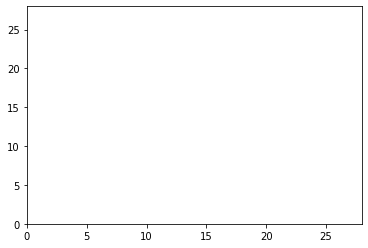

In [10]:
fig = plt.figure() 
ax = plt.axes(xlim=(0, 28), ylim=(0, 28)) 

In [11]:
def frame(w):
 # print(w)

  #ax.clear()
  pixels = total_X[1000,w,:].reshape((28, 28))
  plot=ax.imshow(pixels, cmap='gray')
  w=w+1
    #global x,y,z
    #x=x+np.random.normal(loc=0.0,scale=50.0,size=10)
    #y=y+np.random.normal(loc=0.0,scale=50.0,size=10)
    #z=z+np.random.normal(loc=0.0,scale=50.0,size=10)



    
  return plot

In [12]:
anim = animation.FuncAnimation(fig, frame, frames=15, blit=False, repeat=True)

In [13]:
anim

In [14]:
pip install torchdiffeq


In [15]:
import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.functional as F

parser = argparse.ArgumentParser('ODE demo')
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--nepochs', type=int, default=200)
parser.add_argument('--batch_time', type=int, default=10)
parser.add_argument('--batch_size', type=int, default=20)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--l_rate', type=float, default=1e-3)
parser.add_argument('--adjoint', action='store_true',default=True)
args = parser.parse_args(args=[])

In [16]:
if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

In [17]:
class Dataset(data.Dataset):
    def __init__(self, Xtr):
        self.Xtr = Xtr # N,16,784
    def __len__(self):
        return len(self.Xtr)
    def __getitem__(self, idx):
        return self.Xtr[idx]
# read data
X= loadmat('rot-mnist-3s.mat')['X'].squeeze() # (N, 16, 784)
N = 500
T = 16
Xtr   = torch.tensor(X[:N],dtype=torch.float32).view([N,T,1,28,28])
Xtest = torch.tensor(X[N:],dtype=torch.float32).view([-1,T,1,28,28])
#Xtr   = torch.tensor(X[:N],dtype=torch.float32)
#Xtest = torch.tensor(X[N:],dtype=torch.float32)
# Generators
params = {'batch_size': args.batch_size, 'shuffle': True, 'num_workers': 2}
trainset = Dataset(Xtr)
trainset = data.DataLoader(trainset, **params)
testset  = Dataset(Xtest)
testset  = data.DataLoader(testset, **params)


In [18]:
len(trainset)

25

In [19]:
class ODEFunc(nn.Module):
  def __init__(self):
        # call constructor from superclass
        super().__init__()
        
        # define network layers
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 784)
        
  def forward(self,t, x):
        # define forward pass
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = F.tanh(self.fc4(x))
        x = F.tanh(self.fc5(x))
        return x



In [20]:
class ODEFunc2(nn.Module):
    def __init__(self):
        super(ODEFunc2, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self,t,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [21]:
ODEFunc2()


ODEFunc2(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [22]:
if __name__ == '__main__':

  func = ODEFunc2().to(device)
  optimizer = torch.optim.Adam(func.parameters(),lr=args.l_rate)
  criterion = nn.MSELoss() # mean square error loss
  
  for epoch in range(args.nepochs):
    for i,local_batch in enumerate(trainset):
      #print(i)
      optimizer.zero_grad()
      minibatch = local_batch.to(device)
      batch_y0=minibatch[:,0,:].to(device)
      batch_t=t = torch.linspace(0., 1.,minibatch.shape[1]).to(device)
      pred_y = odeint(func, batch_y0, torch.tensor(batch_t)).to(device)
      pred_y=pred_y.swapaxes(0,1).to(device)
      loss = criterion(pred_y,minibatch)
      loss.backward()
      optimizer.step()
      #print('Here2')
    

    with torch.no_grad():
      true_y0=Xtest[:,0,:].to(device)
      pred_y = odeint(func, true_y0, t).to(device)
      pred_y=pred_y.swapaxes(0,1).to(device)
      loss = criterion(pred_y,Xtest.to(device))

      print('Epoch {:04d} | Total Loss {:.6f}'.format(epoch, loss))
               




  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch 0000 | Total Loss 0.106261
Epoch 0001 | Total Loss 0.102998
Epoch 0002 | Total Loss 0.101072
Epoch 0003 | Total Loss 0.100379
Epoch 0004 | Total Loss 0.099971
Epoch 0005 | Total Loss 0.099705
Epoch 0006 | Total Loss 0.099295
Epoch 0007 | Total Loss 0.098498
Epoch 0008 | Total Loss 0.097222
Epoch 0009 | Total Loss 0.095508
Epoch 0010 | Total Loss 0.094170
Epoch 0011 | Total Loss 0.092809
Epoch 0012 | Total Loss 0.091490
Epoch 0013 | Total Loss 0.090595
Epoch 0014 | Total Loss 0.089763
Epoch 0015 | Total Loss 0.089336
Epoch 0016 | Total Loss 0.088858
Epoch 0017 | Total Loss 0.088460
Epoch 0018 | Total Loss 0.088110
Epoch 0019 | Total Loss 0.087842
Epoch 0020 | Total Loss 0.087577
Epoch 0021 | Total Loss 0.087372
Epoch 0022 | Total Loss 0.087149
Epoch 0023 | Total Loss 0.086974
Epoch 0024 | Total Loss 0.086863
Epoch 0025 | Total Loss 0.086685
Epoch 0026 | Total Loss 0.086527
Epoch 0027 | Total Loss 0.086455
Epoch 0028 | Total Loss 0.086345
Epoch 0029 | Total Loss 0.086201
Epoch 0030

KeyboardInterrupt: ignored

In [23]:
epoch

82

In [24]:
true_y0=Xtest[:,0,:].to(device)
pred_y = odeint(func, true_y0, t).to(device)
pred_y=pred_y.swapaxes(0,1).to(device)
pred_y=pred_y.cpu().detach().numpy()
#pred_y=pred_y.swapaxes(0,1).to(device)

In [25]:
pred_y.shape

(542, 16, 1, 28, 28)

In [26]:
def frame(w):
 # print(w)

  #ax.clear()
  pixels = pred_y[2,w,:].reshape((28, 28))
  plot=ax.imshow(pixels, cmap='gray')
  w=w+1
    #global x,y,z
    #x=x+np.random.normal(loc=0.0,scale=50.0,size=10)
    #y=y+np.random.normal(loc=0.0,scale=50.0,size=10)
    #z=z+np.random.normal(loc=0.0,scale=50.0,size=10)



    
  return plot

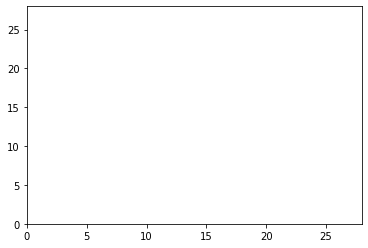

In [27]:
fig = plt.figure() 
ax = plt.axes(xlim=(0, 28), ylim=(0, 28)) 

In [28]:
anim = animation.FuncAnimation(fig, frame, frames=15, blit=False, repeat=True)
anim

In [64]:
minibatch.shape

torch.Size([20, 16, 1, 28, 28])

In [65]:
batch_y0.shape

torch.Size([20, 1, 28, 28])

In [194]:
batch_t

tensor([0.0000, 0.0667, 0.1333, 0.2000, 0.2667, 0.3333, 0.4000, 0.4667, 0.5333,
        0.6000, 0.6667, 0.7333, 0.8000, 0.8667, 0.9333, 1.0000],
       device='cuda:0')

In [141]:
pred_y.shape

torch.Size([542, 16, 784])

In [142]:
Xtest.to(device).shape

torch.Size([542, 16, 784])

In [145]:
loss=nn.MSELoss()

In [147]:
loss(pred_y,Xtest.to(device))

tensor(0.0945, device='cuda:0')

AttributeError: ignored

In [164]:
minibatch.shape

torch.Size([20, 16, 784])

In [167]:
min_new= torch.tensor(minibatch).view([20,16,1,28,28])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [168]:
minibatch.shape

torch.Size([20, 16, 784])

In [70]:
a=torch.ones((3,2))

In [67]:
a

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [71]:
b=torch.zeros((2,3))
b[0,0]=1
b

tensor([[1., 0., 0.],
        [0., 0., 0.]])

In [188]:
8/9

0.8888888888888888

In [198]:
a=torch.arange(10)

In [199]:
a

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [200]:
a.reshape((2,5))

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [208]:
784*20

15680

In [211]:
batch_y0.shape

torch.Size([20, 1, 28, 28])

In [212]:
minibatch.shape

torch.Size([20, 16, 1, 28, 28])

In [222]:
func = ODEFunc2().to(device)
func(batch_y0).shape

torch.Size([20, 784])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([20, 1, 28, 28])

In [239]:
minibatch.shape

torch.Size([20, 16, 1, 28, 28])

In [237]:
batch_y0.shape

torch.Size([20, 1, 28, 28])

In [238]:
Xtest.shape

torch.Size([542, 16, 1, 28, 28])